# **Query SQL**

Query SQL ini sudah dijalankan di google colab

In [5]:
from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()
print('Authenticated')

project_id = "kisi-kisi-400611"
client = bigquery.Client(project=project_id)

In [6]:
df = client.query('''
SELECT
    limit_balance,
    CAST(sex AS INT64) AS sex,
    CAST(education_level AS INT64) AS education_level,
    CAST(marital_status AS INT64) AS marital_status,
    age,
    pay_0,
    pay_2,
    pay_3,
    pay_4,
    CAST(pay_5 AS FLOAT64) AS pay_5,
    CAST(pay_6 AS FLOAT64) AS pay_6,
    bill_amt_1,
    bill_amt_2,
    bill_amt_3,
    bill_amt_4,
    bill_amt_5,
    bill_amt_6,
    pay_amt_1,
    pay_amt_2,
    pay_amt_3,
    pay_amt_4,
    pay_amt_5,
    pay_amt_6,
    CAST(default_payment_next_month AS INT64) AS default_payment_next_month
    
FROM `bigquery-public-data.ml_datasets.credit_card_default` limit 18009

''').to_dataframe()

In [7]:
df.to_csv('P1G5_Set_1_habibi_bagus.csv')

# **Import Libraries**

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import kendalltau
import pickle
import plotly.express  as px 


# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from feature_engine.outliers import Winsorizer , OutlierTrimmer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTENC

# model 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


# **Data Loading**

In [9]:
df = pd.read_csv("P1G5_Set_1_habibi.csv")
# Tampilkan 10 data pertama
print("10 data pertama:")
print(df.head(10))

# Tampilkan 10 data terakhir
print("10 data terakhir:")
print(df.tail(10))

10 data pertama:
   Unnamed: 0  limit_balance  sex  education_level  marital_status   age  \
0           0        80000.0    1                6               1  54.0   
1           1       200000.0    1                4               1  49.0   
2           2        20000.0    2                6               2  22.0   
3           3       260000.0    2                4               2  33.0   
4           4       150000.0    1                4               2  32.0   
5           5       300000.0    2                4               2  32.0   
6           6       130000.0    1                1               1  45.0   
7           7       200000.0    1                1               1  58.0   
8           8       500000.0    1                1               1  39.0   
9           9       230000.0    1                1               1  48.0   

   pay_0  pay_2  pay_3  pay_4  ...  bill_amt_4  bill_amt_5  bill_amt_6  \
0    0.0    0.0    0.0    0.0  ...     29296.0     26210.0     17643.0  

In [10]:
#menghapus kolom dengan nama 'Unnamed: 0' dari DataFrame
del df['Unnamed: 0']

dilihat dari dataset diatas terdapat kolom unnamed: 0 oleh karena itu saya melakukan penghapusan pada kolom tersebut

In [11]:
# Menggunakan df.info() untuk mendapatkan informasi tentang DataFrame df.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   int64  
 2   education_level             2965 non-null   int64  
 3   marital_status              2965 non-null   int64  
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   float64
 10  pay_6                       2965 non-null   float64
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

In [12]:
# menghitung dan mencetak jumlah baris yang duplikat dalam DataFrame
print("Jumlah duplicate :", df.duplicated().sum() )

Jumlah duplicate : 1


In [13]:
#menghapus atau mendrop duplicates dari DataFrame
df.drop_duplicates()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,...,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,...,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,...,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,...,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,...,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2960,80000.0,2,3,2,28.0,-1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0,0
2961,50000.0,2,3,1,51.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0,1
2962,450000.0,2,2,1,38.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,1
2963,50000.0,2,2,1,44.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0,0


dikarenakan ada 1 data duplicate maka saya akan mendrop data duplicate tersebut

In [14]:
# menghitung jumlah nilai yang null dalam setiap kolom DataFrame
df.isnull().sum()

limit_balance                 0
sex                           0
education_level               0
marital_status                0
age                           0
pay_0                         0
pay_2                         0
pay_3                         0
pay_4                         0
pay_5                         0
pay_6                         0
bill_amt_1                    0
bill_amt_2                    0
bill_amt_3                    0
bill_amt_4                    0
bill_amt_5                    0
bill_amt_6                    0
pay_amt_1                     0
pay_amt_2                     0
pay_amt_3                     0
pay_amt_4                     0
pay_amt_5                     0
pay_amt_6                     0
default_payment_next_month    0
dtype: int64

setelah di cek tidak terdapat data null

In [15]:
df.isna().sum()

limit_balance                 0
sex                           0
education_level               0
marital_status                0
age                           0
pay_0                         0
pay_2                         0
pay_3                         0
pay_4                         0
pay_5                         0
pay_6                         0
bill_amt_1                    0
bill_amt_2                    0
bill_amt_3                    0
bill_amt_4                    0
bill_amt_5                    0
bill_amt_6                    0
pay_amt_1                     0
pay_amt_2                     0
pay_amt_3                     0
pay_amt_4                     0
pay_amt_5                     0
pay_amt_6                     0
default_payment_next_month    0
dtype: int64

setelah di cek tidak terdapat data NaN

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
limit_balance,2965.0,163369.308600,125030.415472,10000.0,50000.0,140000.0,230000.0,800000.0
sex,2965.0,1.607757,0.488333,1.0,1.0,2.0,2.0,2.0
education_level,2965.0,1.849578,0.778184,0.0,1.0,2.0,2.0,6.0
marital_status,2965.0,1.559865,0.522317,0.0,1.0,2.0,2.0,3.0
age,2965.0,35.193255,9.109439,21.0,28.0,34.0,41.0,69.0
pay_0,2965.0,0.005059,1.114395,-2.0,-1.0,0.0,0.0,8.0
pay_2,2965.0,-0.122428,1.180784,-2.0,-1.0,0.0,0.0,7.0
pay_3,2965.0,-0.141653,1.183630,-2.0,-1.0,0.0,0.0,7.0
pay_4,2965.0,-0.185160,1.178322,-2.0,-1.0,0.0,0.0,8.0
pay_5,2965.0,-0.225295,1.159003,-2.0,-1.0,0.0,0.0,7.0


In [17]:
# Membuat salinan (copy) dari DataFrame df dan menyimpannya dalam variabel data.
data_cleaned = df.copy()

print("Berhasil Membuat Salinan")

Berhasil Membuat Salinan


# **Exploratory Data Analysis (EDA)**

#### **Melihat Perbandingan Credit Card Defaulter**

Text(0.5, 1.0, 'jumlah defaulter')

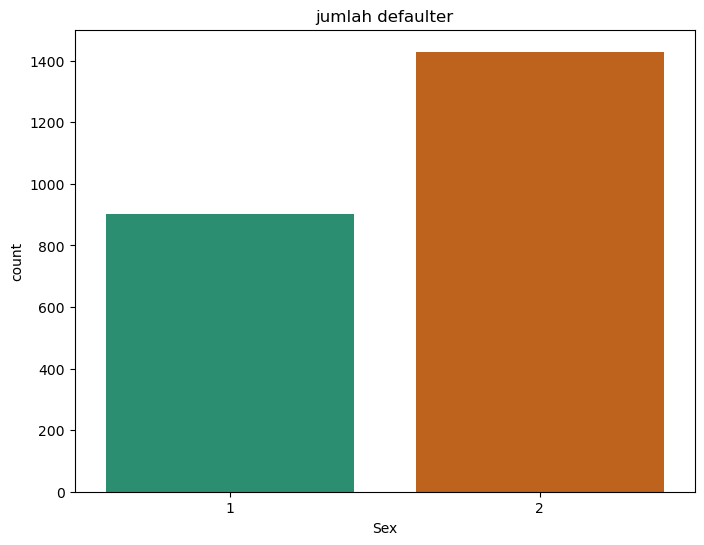

In [18]:
plt.figure(figsize=(8, 6))
df1 = data_cleaned[data_cleaned['default_payment_next_month'] == 0]
sns.countplot(data=df1, x='sex', palette='Dark2')
plt.xlabel('Sex')
plt.title('jumlah defaulter')


dilihat dari hasil diatas menunjukan bahwa wanita menjadi credit card defaulter lebih banyak dibandingkan pria

#### **jumlah Defaulter pada data**

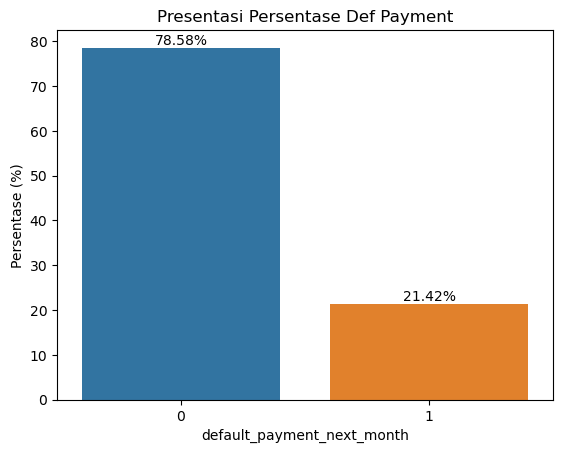

In [19]:
# Menghitung jumlah masing-masing nilai dalam kolom 'default_payment_next_month' dan menyimpannya dalam count_data.
count_data = data_cleaned['default_payment_next_month'].value_counts()

# Menghitung jumlah total data dalam DataFrame.
total_data = len(data_cleaned)

# Menghitung persentase masing-masing nilai dalam kolom 'default_payment_next_month' dalam bentuk persen.
percentage_data = (count_data / total_data) * 100

# Menggunakan Seaborn untuk membuat diagram batang yang menunjukkan persentase nilai dalam kolom 'default_payment_next_month'.
sns.barplot(x=percentage_data.index, y=percentage_data.values)

# Menambahkan judul, label sumbu, dan teks persentase pada diagram batang.
plt.title('Presentasi Persentase Def Payment')
plt.xlabel('default_payment_next_month')
plt.ylabel('Persentase (%)')

# Menambahkan teks persentase pada setiap batang diagram.
for i in range(len(percentage_data)):
    plt.text(i, percentage_data[i], f'{percentage_data[i]:.2f}%', ha='center', va='bottom')

# Menampilkan diagram batang.
plt.show()

Dari Hasil yang ditampilkan data kelihatan inbalance serta ternyata ada sekitar 21,42% Pemilik kartu kredit yang terindikasi sebagai Credit Card Defaulter dan 78,58% pemilik kartu kredit bisa membayar .

#### **persebaran Limit Balance dari pengguna kartu kredit?**

In [20]:
fig1 = px.histogram(data_cleaned, x='limit_balance',
                    title='Distribusi Limit Balance',
                    labels={'x': 'Dollar($)', 'y': 'Number of card'})
fig1.show()


Range Limit balance dengan jumlah tertinggi berada pada 40.000-50.000 USD dan dapat dilihat juga dari visualisasi diatas dapat dilihat bahwa yang memakai kartu kredit dengan limit kecil lebih mendominasi dibandingkan dengan limit yang besar

#### **persentase pemegang kartu kredit berdasarkan tingkat pendidikannya**

In [21]:
# mengganti value education level 4,5,6 dan 0 menjadi 4, karena tidak menjelaskan kelompok education level manapun
data_cleaned.loc[data_cleaned['education_level'] == 0, 'education_level'] = 4
data_cleaned.loc[data_cleaned['education_level'] == 4, 'education_level'] = 4
data_cleaned.loc[data_cleaned['education_level'] == 5, 'education_level'] = 4
data_cleaned.loc[data_cleaned['education_level'] == 6, 'education_level'] = 4

# membuat df2 dimana education level dibuatkan menjadi text sesuai ketentuan dibawah
# dibuat menjadi text agar lebih mudah dipahami pie chartnya.
df3 = data_cleaned['education_level'].value_counts().reset_index()
df3.columns = ['Education', 'No of people']
df3.loc[df3['Education'] == 1, 'Education'] = 'Graduate School'
df3.loc[df3['Education'] == 2, 'Education'] = 'University'
df3.loc[df3['Education'] == 3, 'Education'] = 'High School'
df3.loc[df3['Education'] == 4, 'Education'] = 'Others'

# memplot df2 ke pie chart
fig3 = px.pie(df3, values='No of people', names='Education', color_discrete_sequence=px.colors.sequential.Plasma,
              title='Education qualification of credit card holder')
fig3.show()


dilihat dari pie chart diatas bahwa kebanyakan pemegang kartu kredit adalah lulusan univesitas

#### **membandingkan distribusi usia antara pelanggan yang "Bayar" dan "Tidak Bayar" pada bulan berikutnya**

In [22]:
# Membuat histogram menggunakan Plotly Express dengan warna dan label
fig = px.histogram(data_frame=data_cleaned, x='age', color='default_payment_next_month', nbins=30,
                   labels={'age': 'Usia', 'default_payment_next_month': 'Default Payment'},
                   title='Perbandingan Distribusi Usia antara Pelanggan yang Bayar dan Tidak Bayar pada Bulan Berikutnya')

# Menyesuaikan skala warna
fig.update_traces(marker=dict(opacity=0.5), selector=dict(type='histogram'))
fig.update_layout(showlegend=True)

# Memperbarui label legenda
fig.for_each_trace(lambda t: t.update(name='Bayar' if t.name == '0' else 'Tidak Bayar'))

# Menampilkan histogram
fig.show()


dilihat dari data diatas didapatkan usia 30-31 adalah yang tertinggi membayar dan usia 24-25 yang paling banyak tidak bayar

# **Feature Engineering**

#### **Cardinality Analysis**

In [23]:
print('marital_status    : {}'.format(len(data_cleaned.marital_status.unique())))
print('age               : {}'.format(len(data_cleaned.age.unique())))
print('education_level   : {}'.format(len(data_cleaned.education_level.unique())))
print('sex               : {}'.format(len(data_cleaned.sex.unique())))


marital_status    : 4
age               : 49
education_level   : 4
sex               : 2


didapatkan cardinalitas paling tinggi adalah age dengan 49. Disini saya menganggap bahwa itu masih dibatas aman

#### **Split Between X and Y**

In [24]:
X = data_cleaned.drop(['default_payment_next_month'], axis = 1)
y = data_cleaned['default_payment_next_month']
X

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
0,80000.0,1,4,1,54.0,0.0,0.0,0.0,0.0,0.0,...,62290.0,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,...,50942.0,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0
2,20000.0,2,4,2,22.0,0.0,0.0,0.0,0.0,0.0,...,15535.0,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,...,27086.0,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,...,161192.0,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2960,80000.0,2,3,2,28.0,-1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0
2961,50000.0,2,3,1,51.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,5880.0,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0
2962,450000.0,2,2,1,38.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0
2963,50000.0,2,2,1,44.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0


#### **Split Between Train-set and Test-set**

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 20)

print('Train size', X_train.shape)
print('Test size', X_test.shape)
print('Test size', y_test.shape)
print('Test size', y_test.shape)

X_train

Train size (2075, 23)
Test size (890, 23)
Test size (890,)
Test size (890,)


,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
1155,200000.0,1,3,1,43.0,0.0,0.0,0.0,0.0,0.0,...,154977.0,157166.0,160870.0,164101.0,5404.0,5854.0,5000.0,5000.0,4600.0,5000.0
2874,110000.0,2,2,1,48.0,1.0,-2.0,-2.0,-2.0,-2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
388,260000.0,2,1,1,31.0,-1.0,-1.0,0.0,0.0,0.0,...,27201.0,27879.0,28420.0,39206.0,8078.0,20000.0,2000.0,2000.0,12000.0,0.0
2882,400000.0,2,2,2,40.0,1.0,-2.0,-2.0,-2.0,-2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2860,360000.0,2,2,2,28.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1814,150000.0,1,1,2,37.0,2.0,2.0,2.0,2.0,2.0,...,35985.0,38687.0,37765.0,40352.0,1600.0,0.0,3300.0,0.0,3200.0,1700.0
1428,100000.0,1,2,1,34.0,2.0,2.0,2.0,0.0,0.0,...,64930.0,58433.0,50859.0,40005.0,2300.0,2000.0,4500.0,3300.0,0.0,3500.0
2441,300000.0,1,3,1,45.0,-1.0,-1.0,-1.0,2.0,-1.0,...,780.0,390.0,780.0,780.0,390.0,780.0,0.0,780.0,0.0,0.0
271,300000.0,2,1,1,51.0,0.0,0.0,0.0,0.0,0.0,...,90069.0,85008.0,83983.0,50257.0,4107.0,7346.0,65000.0,2500.0,2022.0,1800.0


#### **Handling Outlier**

In [26]:
num_col = data_cleaned[['limit_balance', 'age', 
       'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6',
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5',
       'pay_amt_6']]

In [27]:
for i in num_col.columns:
    skew = X_train[i].skew()
    if skew >0.5 and skew <= 1 :
        Q1 = data_cleaned[i].quantile(0.25)
        Q3 = data_cleaned[i].quantile(0.75)
        IQR = Q3 - Q1

        upper_boundary = Q3 + (1.5*IQR)
        lower_boundary = Q1 - (1.5*IQR)

    elif skew >1 :
        Q1 = data_cleaned[i].quantile(0.25)
        Q3 = data_cleaned[i].quantile(0.75)
        IQR = Q3 - Q1

    upper_boundary = Q3 + (3*IQR)
    lower_boundary = Q1 - (3*IQR)

    outlier = X_train[(X_train[i]>upper_boundary)|((X_train[i]<lower_boundary))]
    persen_outlier = len(outlier)/len(X_train)*100

    print('Persentase outlier dari kolom', i ,'adalah', persen_outlier, '%')

Persentase outlier dari kolom limit_balance adalah 0.0 %
Persentase outlier dari kolom age adalah 0.0 %
Persentase outlier dari kolom bill_amt_2 adalah 2.506024096385542 %
Persentase outlier dari kolom bill_amt_3 adalah 2.7951807228915664 %
Persentase outlier dari kolom bill_amt_4 adalah 2.506024096385542 %
Persentase outlier dari kolom bill_amt_5 adalah 2.36144578313253 %
Persentase outlier dari kolom bill_amt_6 adalah 2.216867469879518 %
Persentase outlier dari kolom pay_amt_1 adalah 5.397590361445783 %
Persentase outlier dari kolom pay_amt_2 adalah 5.686746987951807 %
Persentase outlier dari kolom pay_amt_3 adalah 5.493975903614458 %
Persentase outlier dari kolom pay_amt_4 adalah 4.337349397590361 %
Persentase outlier dari kolom pay_amt_5 adalah 4.91566265060241 %
Persentase outlier dari kolom pay_amt_6 adalah 4.819277108433735 %


In [28]:
# Cek apakah distribusi normal atau tidak

print('Distribusi kolom limit_balance   : ', X_train['limit_balance'].skew())
print('Distribusi kolom age             : ', X_train['age'].skew())
print('Distribusi kolom bill_amt_1      : ', X_train['bill_amt_1'].skew())
print('Distribusi kolom bill_amt_2      : ', X_train['bill_amt_2'].skew())
print('Distribusi kolom bill_amt_3      : ', X_train['bill_amt_3'].skew())
print('Distribusi kolom bill_amt_4      : ', X_train['bill_amt_4'].skew())
print('Distribusi kolom bill_amt_5      : ', X_train['bill_amt_5'].skew())
print('Distribusi kolom bill_amt_6      : ', X_train['bill_amt_6'].skew())
print('Distribusi kolom pay_amt_1       : ', X_train['pay_amt_1'].skew())
print('Distribusi kolom pay_amt_2       : ', X_train['pay_amt_2'].skew())
print('Distribusi kolom pay_amt_3       : ', X_train['pay_amt_3'].skew())
print('Distribusi kolom pay_amt_4       : ', X_train['pay_amt_4'].skew())
print('Distribusi kolom pay_amt_5       : ', X_train['pay_amt_5'].skew())
print('Distribusi kolom pay_amt_6       : ', X_train['pay_amt_6'].skew())

Distribusi kolom limit_balance   :  0.9011828859798081
Distribusi kolom age             :  0.751241700536757
Distribusi kolom bill_amt_1      :  2.41975322604187
Distribusi kolom bill_amt_2      :  2.428964065769197
Distribusi kolom bill_amt_3      :  2.6674408258114473
Distribusi kolom bill_amt_4      :  2.4870107786185356
Distribusi kolom bill_amt_5      :  2.3754430332619045
Distribusi kolom bill_amt_6      :  2.361348858310716
Distribusi kolom pay_amt_1       :  12.076430511422101
Distribusi kolom pay_amt_2       :  32.16079125751732
Distribusi kolom pay_amt_3       :  8.660603728882862
Distribusi kolom pay_amt_4       :  8.510264403353048
Distribusi kolom pay_amt_5       :  8.884634409048964
Distribusi kolom pay_amt_6       :  8.160943633413659


In [29]:
winsoriser_price = Winsorizer(capping_method='gaussian', # gaussian itu distribusi normal
                             tail='both', #capping 2 sisi outlier
                             fold=3, # rumus gaussian
                             variables=['limit_balance', 'age', 
       'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6',
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5',
       'pay_amt_6'])

X_train_capped = winsoriser_price.fit_transform(X_train)
X_test_capped = winsoriser_price.transform(X_test)

In [30]:
# Buat function membuat histogram dan boxplot, untuk lihat perubahan setelah capping 
def capping_plot(data, variable):
    # Definisikan figure size
    plt.figure(figsize=(16, 4))

    # membuat Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data[variable], bins=30)
    plt.title('Histogram')

    # membuat Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=data[variable])
    plt.title('Boxplot')

    plt.show()

Data Train
age - Before Capping


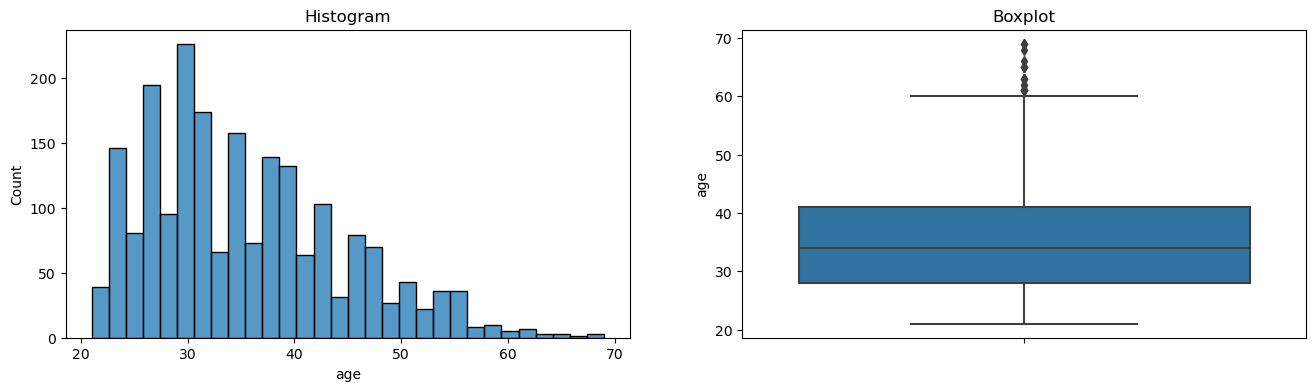


age - After Capping


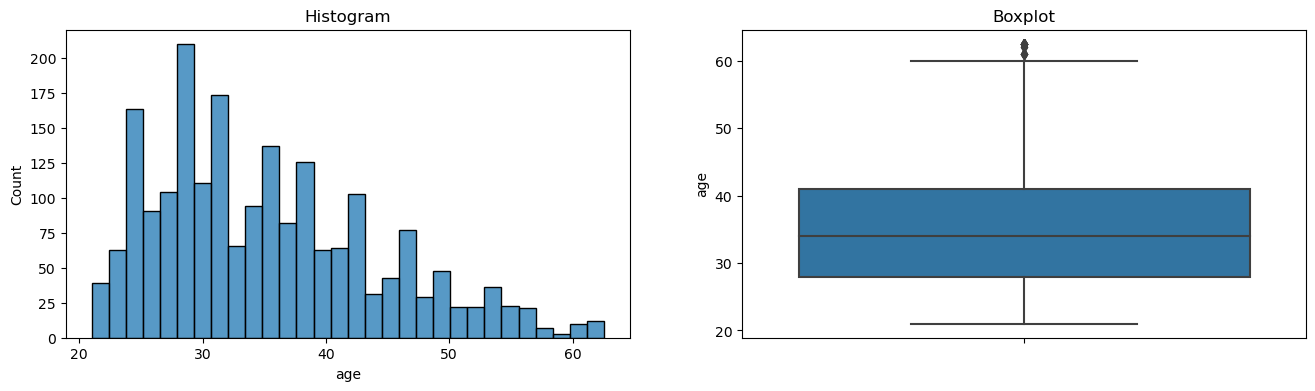

bill_amt_1 - Before Capping


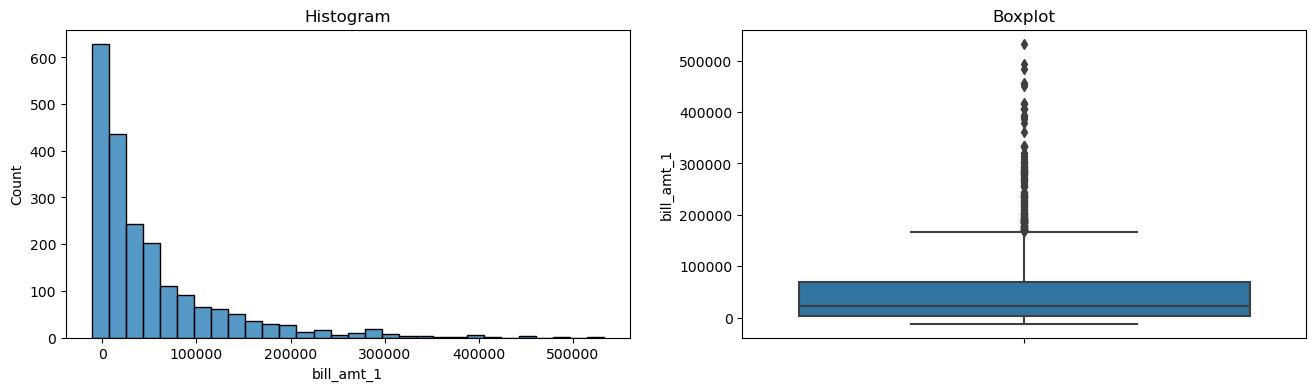


bill_amt_1- After Capping


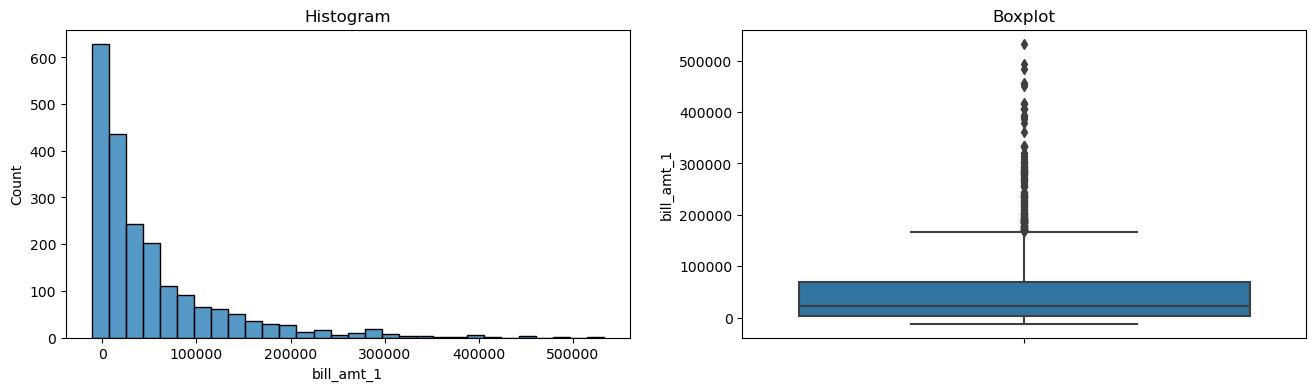

bill_amt_2 - Before Capping


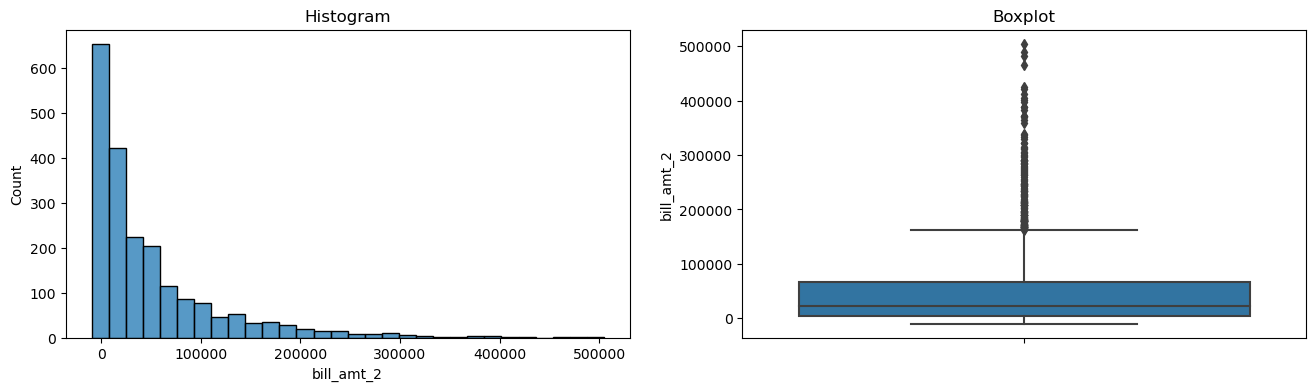


bill_amt_2 - After Capping


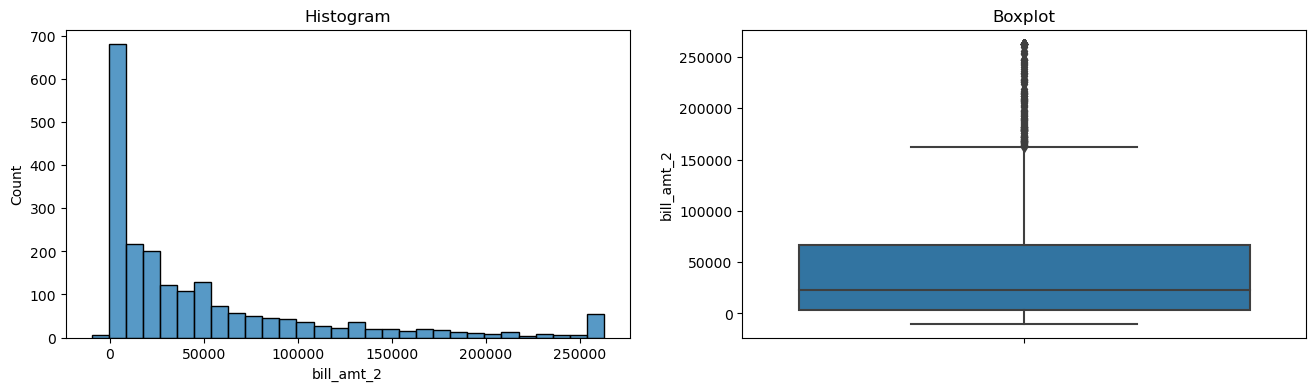

Data test
age - Before Capping


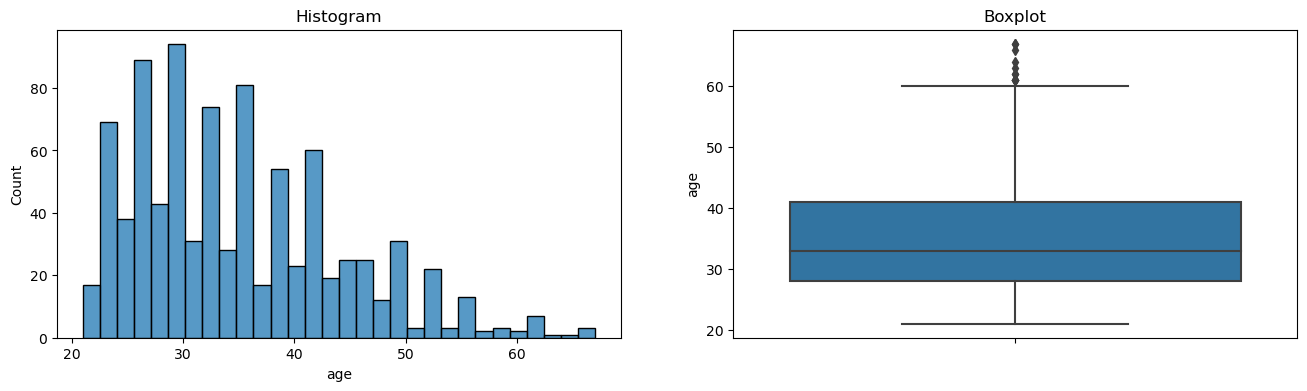


age - After Capping


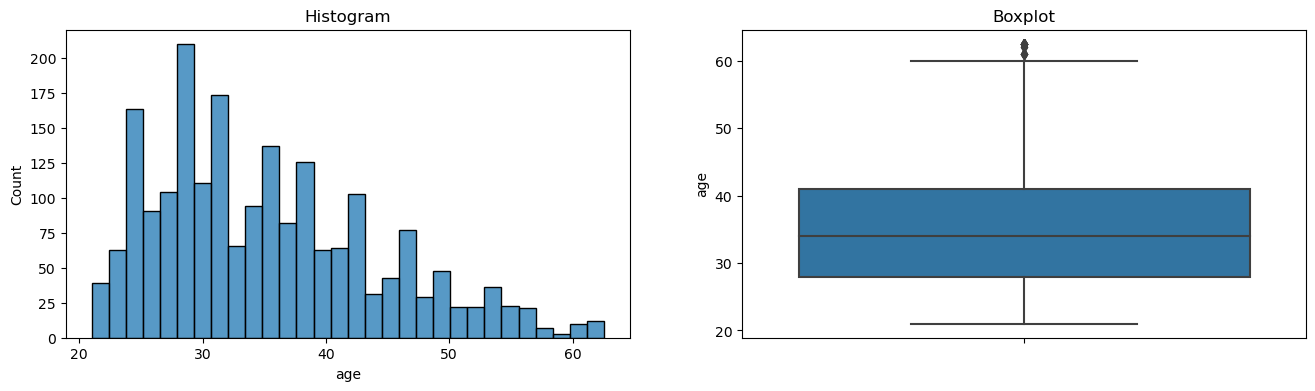

In [31]:
print('Data Train')
print('age - Before Capping')
capping_plot(X_train, 'age')
print('\nage - After Capping')
capping_plot(X_train_capped, 'age')

print('bill_amt_1 - Before Capping')
capping_plot(X_train, 'bill_amt_1')
print('\nbill_amt_1- After Capping')
capping_plot(X_train_capped, 'bill_amt_1')

print('bill_amt_2 - Before Capping')
capping_plot(X_train, 'bill_amt_2')
print('\nbill_amt_2 - After Capping')
capping_plot(X_train_capped, 'bill_amt_2')


print('Data test')
print('age - Before Capping')
capping_plot(X_test, 'age')

print('\nage - After Capping')
capping_plot(X_train_capped, 'age')


data sudah di capping dan ternyata masih ada outlier tapi tidak apa karena model tidak sensitif pada outlier

#### **Feature Selection**

**Cek Korelasi Data 'Pay' Dengan Target 'default_payment_next_month'**

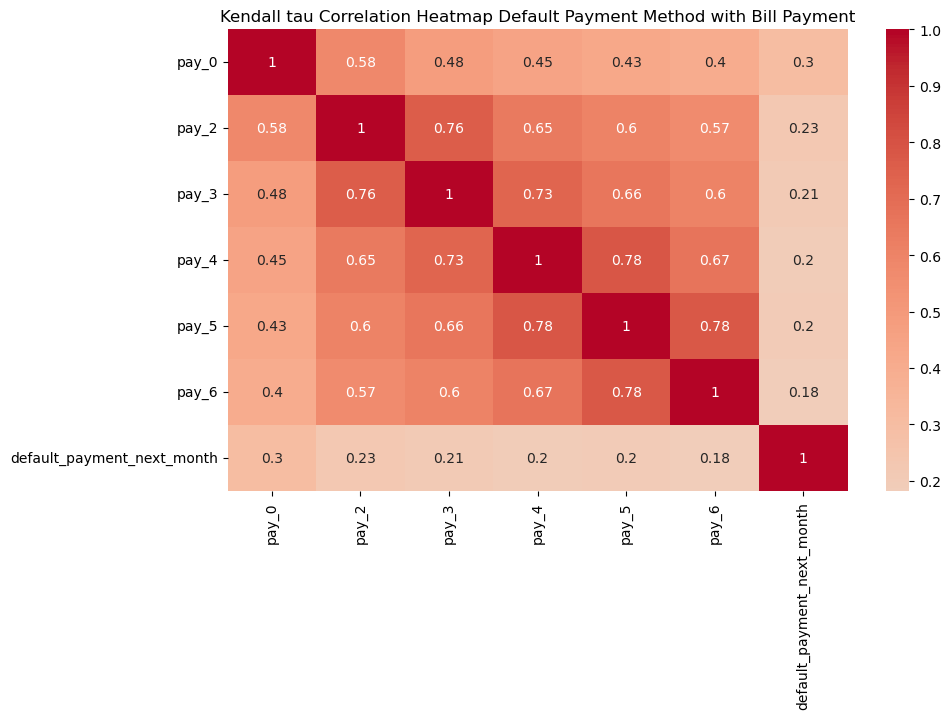

In [32]:
pay_col = data_cleaned[['pay_0', 'pay_2', 'pay_3', 'pay_4','pay_5','pay_6','default_payment_next_month']]

kendall_corr_matrix = pay_col.corr(method=lambda x, y: kendalltau(x, y).correlation)

plt.figure(figsize=(10, 6))
sns.heatmap(kendall_corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Kendall tau Correlation Heatmap Default Payment Method with Bill Payment')
plt.show()

setelah di cek menggunakan kendall ternyata semua kolom memiliki korelasi dengan target sehingga akan menjadi feature

**Cek Korelasi kolom 'bill_amount' dengan target 'default_payment_next_month'**

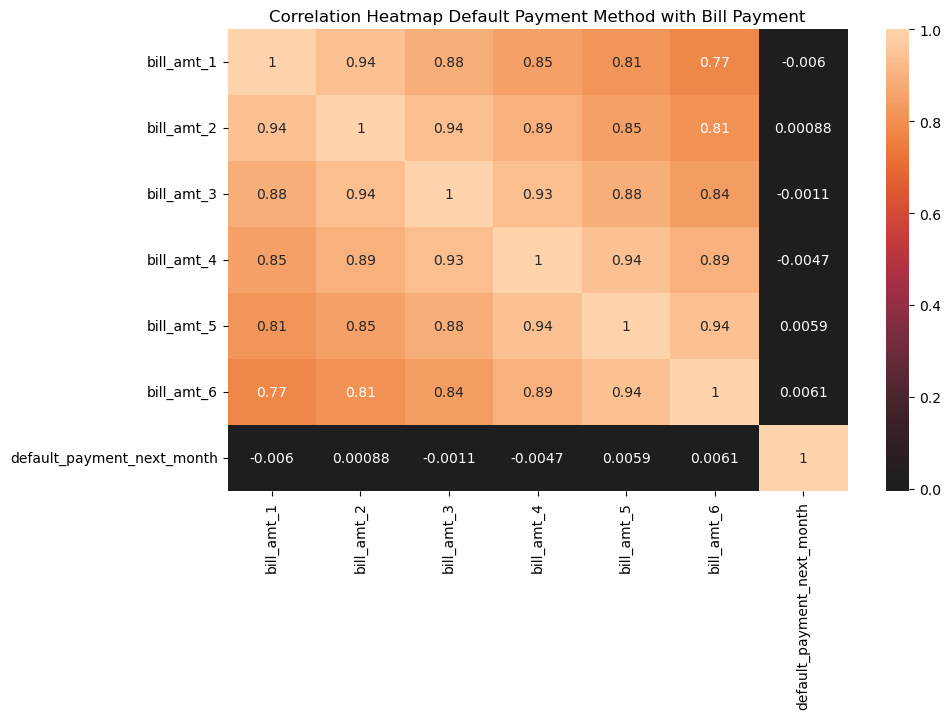

In [33]:
#Menghitung kolerasi def_payment dengan 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4','bill_amt_5','bill_amt_6'
bill_col = data_cleaned[['bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4','bill_amt_5','bill_amt_6','default_payment_next_month']]

plt.figure(figsize=(10, 6))
sns.heatmap(bill_col.corr(), annot=True, center=0)
plt.title('Correlation Heatmap Default Payment Method with Bill Payment')
plt.show()

setelah di cek menggunakan pearson ternyata semua kolom tidak memiliki korelasi dengan target sehingga tidak akan menjadi feature

**Mencari korelasi kolom 'pay_amt' dengan target 'default_payment_next_month'**

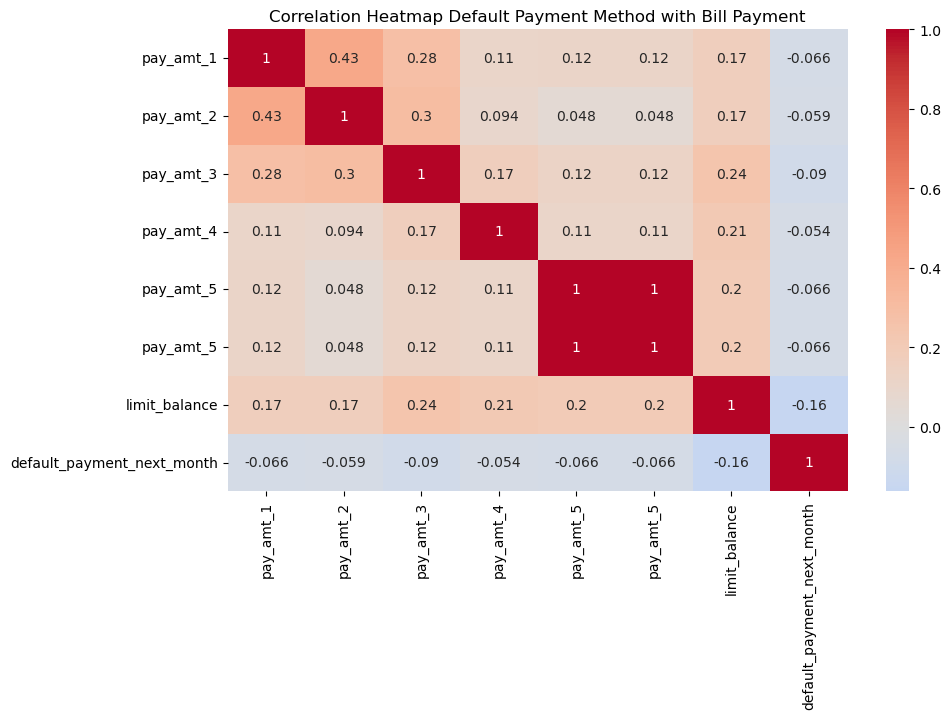

In [34]:
#Menghitung kolerasi def_payment dengan 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4','pay_amt_5','pay_amt_5','limit_balance'
pay_amt_corr = data_cleaned[['pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4','pay_amt_5','pay_amt_5','limit_balance','default_payment_next_month']]

plt.figure(figsize=(10, 6))
sns.heatmap(pay_amt_corr.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap Default Payment Method with Bill Payment')
plt.show()

setelah di cek ternyata limit_balance yang paling tinggi korelasinya sehingga akan menjadi feature

**Mencari korelasi kolom 'sex','education_level','marital_status','age' dengan target 'default_payment_next_month'**

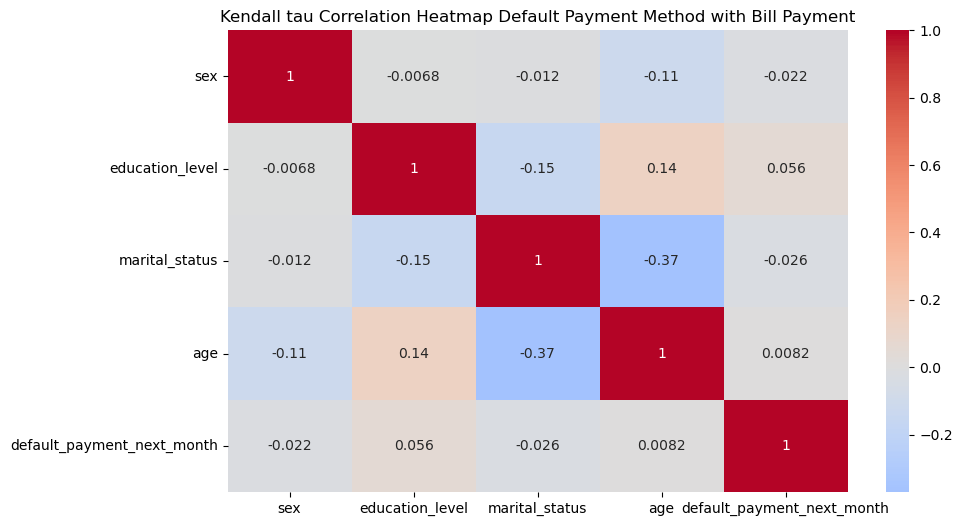

In [35]:
# Menghitung kolerasi def_payment dengan 'sex', 'education_level', 'marital_status', 'age'
status_corr = data_cleaned[['sex', 'education_level', 'marital_status', 'age', 'default_payment_next_month']]

kendall_corr_matrix = status_corr.corr(method=lambda x, y: kendalltau(x, y).correlation)

plt.figure(figsize=(10, 6))
sns.heatmap(kendall_corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Kendall tau Correlation Heatmap Default Payment Method with Bill Payment')
plt.show()

setelah di cek ternyata semua kolom tidak memiliki korelasi dengan target sehingga tidak akan menjadi feature

### **Split Between Numerical and Categorical**

In [36]:
X_train_selection=X_train_capped[['limit_balance','pay_0', 'pay_2', 'pay_3', 'pay_4','pay_5','pay_6']]
X_test_selection=X_test_capped[['limit_balance','pay_0', 'pay_2', 'pay_3', 'pay_4','pay_5','pay_6']]

X_train_selection

,limit_balance,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6
1155,200000.0,0.0,0.0,0.0,0.0,0.0,0.0
2874,110000.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0
388,260000.0,-1.0,-1.0,0.0,0.0,0.0,0.0
2882,400000.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0
2860,360000.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
...,...,...,...,...,...,...,...
1814,150000.0,2.0,2.0,2.0,2.0,2.0,2.0
1428,100000.0,2.0,2.0,2.0,0.0,0.0,2.0
2441,300000.0,-1.0,-1.0,-1.0,2.0,-1.0,0.0
271,300000.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
num_col_ok = X_train_selection[['limit_balance']].columns.tolist()
cat_col_ok = X_train_selection[['pay_0', 'pay_2', 'pay_3', 'pay_4','pay_5','pay_6']].columns.tolist()

In [38]:
X_train_num = X_train[num_col_ok]
X_train_cat = X_train[cat_col_ok]

X_test_num = X_test[num_col_ok]
X_test_cat = X_test[cat_col_ok]

X_train_num

,limit_balance
1155,200000.0
2874,110000.0
388,260000.0
2882,400000.0
2860,360000.0
...,...
1814,150000.0
1428,100000.0
2441,300000.0
271,300000.0


### **Feature Scalling**

In [39]:
# melakukan scalling dengan menggunakan standard scaller
scaler = MinMaxScaler()
model = scaler.fit(X_train_num[['limit_balance']])
train_scaller = model.transform(X_train_num[['limit_balance']])
test_scaller = scaler.transform(X_test_num[['limit_balance']])
train_scaller

array([[0.27536232],
       [0.14492754],
       [0.36231884],
       ...,
       [0.42028986],
       [0.42028986],
       [0.14492754]])

### **Concate Data**

In [40]:
X_train_final = np.concatenate([train_scaller, X_train_cat], axis=1)
X_test_final = np.concatenate([test_scaller, X_test_cat], axis=1)

In [41]:
X_train_final

array([[ 0.27536232,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.14492754,  1.        , -2.        , ..., -2.        ,
        -2.        , -2.        ],
       [ 0.36231884, -1.        , -1.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.42028986, -1.        , -1.        , ...,  2.        ,
        -1.        ,  0.        ],
       [ 0.42028986,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.14492754, -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ]])

### **SmoteNC**

karena data inbalance maka saya akan membalance data dengan smotenc

In [42]:
# melakukan smotenc untuk membalancekan data
smotenc = SMOTENC([1,2,3,4,5,6], random_state = 60)
x_train_balanced, y_train_balanced = smotenc.fit_resample(X_train_final, y_train)
y_train_balanced.value_counts()

0    1635
1    1635
Name: default_payment_next_month, dtype: int64

In [43]:
#membuat variabel baru data yang sudah balance
X_train_finals= x_train_balanced
y_trains= y_train_balanced

# **Model Definition**

#### **Model Logistic Regression**

In [44]:
# define model Logistic Refression
logreg = LogisticRegression()
logreg.fit(X_train_finals, y_trains)

print('Coefficient : ', logreg.coef_)
print('Intercept   : ', logreg.intercept_)

Coefficient :  [[-1.02758889  0.5702173  -0.1222223   0.18584408 -0.02391532  0.08998582
   0.00686544]]
Intercept   :  [0.07879414]


**Default Value Logistic Regression X_train**

In [45]:
#default value dari model logistic regression (data x train)
y_train_predict_logreg = logreg.predict(X_train_finals)
print('Default Value Logistic Regression X_train')
print(classification_report(y_trains,y_train_predict_logreg))

Default Value Logistic Regression X_train
              precision    recall  f1-score   support

           0       0.67      0.70      0.68      1635
           1       0.68      0.66      0.67      1635

    accuracy                           0.68      3270
   macro avg       0.68      0.68      0.68      3270
weighted avg       0.68      0.68      0.68      3270



**Default Value Logistic Regression X_test**

In [46]:
#default value dari model logistic regression (data x test)
y_test_predict_logreg = logreg.predict(X_test_final)
print('Default Value Logistic Regression X_test')
print(classification_report(y_test,y_test_predict_logreg))

Default Value Logistic Regression X_test
              precision    recall  f1-score   support

           0       0.88      0.73      0.80       695
           1       0.40      0.65      0.50       195

    accuracy                           0.71       890
   macro avg       0.64      0.69      0.65       890
weighted avg       0.78      0.71      0.73       890



#### **Model KNN**

In [47]:
#define model KNN
knn = KNeighborsClassifier()
knn.fit(X_train_finals, y_trains)

KNeighborsClassifier()

In [48]:
#Default value di model KNN dari data x train
y_train_predict_knn = knn.predict(X_train_finals)
print('Default Value KNN data X_train')
print(classification_report(y_trains,y_train_predict_knn))

Default Value KNN data X_train
              precision    recall  f1-score   support

           0       0.77      0.88      0.82      1635
           1       0.86      0.74      0.80      1635

    accuracy                           0.81      3270
   macro avg       0.82      0.81      0.81      3270
weighted avg       0.82      0.81      0.81      3270



In [49]:
#melihat nilai default model KNN dari data x test
y_test_predict_knn = knn.predict(X_test_final)
print('Default Value KNN dari Data X_test')
print(classification_report(y_test,y_test_predict_knn))

Default Value KNN dari Data X_test
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       695
           1       0.46      0.47      0.47       195

    accuracy                           0.76       890
   macro avg       0.66      0.66      0.66       890
weighted avg       0.77      0.76      0.76       890



didapatkan nilai defult KNN f1_score memiliki nilai range train 0.80 dan test 0.47

#### **Model SVM**

In [50]:
#define model SVM
svm = SVC()
svm.fit(X_train_finals, y_trains)

SVC()

In [51]:
#Default Value model SVM dari data x train
y_train_predict_svm = svm.predict(X_train_finals)
print('Default Value SVM data X_train')
print(classification_report(y_trains,y_train_predict_svm))

Default Value SVM data X_train
              precision    recall  f1-score   support

           0       0.67      0.87      0.76      1635
           1       0.81      0.58      0.68      1635

    accuracy                           0.72      3270
   macro avg       0.74      0.72      0.72      3270
weighted avg       0.74      0.72      0.72      3270



In [52]:
#melihat nilai default model SVM dari data x test
y_test_predict_svm = svm.predict(X_test_final)
print('Default Value SVM data X_test')
print(classification_report(y_test,y_test_predict_svm))

Default Value SVM data X_test
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       695
           1       0.52      0.56      0.54       195

    accuracy                           0.79       890
   macro avg       0.70      0.71      0.70       890
weighted avg       0.80      0.79      0.79       890



didapatkan nilai defult KNN f1_score memiliki nilai range train 0.68 dan test 0.54

#### **Cross validation**

melakukan cross validation untuk melihat nilai f1 yang muncul apakah itu sebuah kebetulan dan akan diambil nilai yang terbaik dan dijadikan model di hyperparametertuning dan ditraining dan dievuluasi

**Dengan Metode Log Regression**

In [53]:
f1_train_cross_val = cross_val_score(logreg,
                                     X_train_finals,
                                     y_trains,
                                     cv=5,
                                     scoring="f1")

print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean()-f1_train_cross_val.std()) , '-', (f1_train_cross_val.mean()+f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.6874028  0.71869919 0.65767285 0.63141026 0.66165414]
F1 Score - Mean - Cross Validation :  0.6713678456068142
F1 Score - Std - Cross Validation  :  0.029583419776323304
F1 Score - Range of Test-Set       :  0.6417844258304909 - 0.7009512653831375


didapat nilai STD adalah 0,029 model adalah best fit

**Dengan Metode KNN**

In [54]:
f1_train_cross_val = cross_val_score(knn,
                                     X_train_finals,
                                     y_trains,
                                     cv=5,
                                     scoring="f1")

print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean()-f1_train_cross_val.std()) , '-', (f1_train_cross_val.mean()+f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.67790894 0.75737705 0.78640777 0.74666667 0.76415094]
F1 Score - Mean - Cross Validation :  0.7465022727677818
F1 Score - Std - Cross Validation  :  0.036680396563206034
F1 Score - Range of Test-Set       :  0.7098218762045758 - 0.7831826693309878


didapat nilai STD adalah 0,036 model adalah best fit

**Dengan Metode SVM**

In [55]:
f1_train_cross_val = cross_val_score(svm,
                                     X_train_finals,
                                     y_trains,
                                     cv=5,
                                     scoring="f1")

print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean()-f1_train_cross_val.std()) , '-', (f1_train_cross_val.mean()+f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.70376432 0.69518717 0.65474061 0.61732852 0.67595819]
F1 Score - Mean - Cross Validation :  0.6693957605597769
F1 Score - Std - Cross Validation  :  0.03103298572583294
F1 Score - Range of Test-Set       :  0.638362774833944 - 0.7004287462856098


didapat nilai STD adalah 0,031 model adalah best fit

Kesimpulan : dari hasil cross validation didapatkan bahwa model KNN adalah yang paling bagus dengan nilai f1 score - range of test 0,70 - 0,78 dan akan dilakukan hypertunning

# **Model Training**

In [56]:
grid_search_params = {
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
}

In [57]:
rf_gridcv = GridSearchCV(estimator=KNeighborsClassifier(),
                         param_grid=grid_search_params,
                         cv=5,
                         n_jobs=-1,
                         verbose=2,
                         scoring='f1')

rf_gridcv.fit(X_train_final, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring='f1', verbose=2)

In [58]:
# memanggil parameter terbaik dalam random cv 
rf_gridcv.best_params_

{'algorithm': 'auto', 'p': 1, 'weights': 'uniform'}

Parameter terbaik adalah :
- Pada Weights : menggunakan uniform
- Nilai P nya 1
- Dan algorithm nya menggunakan auto

In [59]:
# Get Best Estimator
rf_gridcv_best = rf_gridcv.best_estimator_

F1 Score - Train Set  :  0.6302886516409648 

Classification Report : 
               precision    recall  f1-score   support

           0       0.65      0.94      0.77      1635
           1       0.89      0.49      0.63      1635

    accuracy                           0.71      3270
   macro avg       0.77      0.71      0.70      3270
weighted avg       0.77      0.71      0.70      3270
 



Confusion Matrix      : 


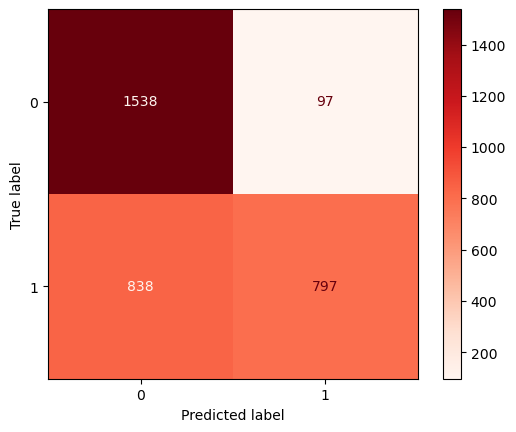

In [60]:
y_pred_train_finals = rf_gridcv_best.predict(X_train_finals)

print('F1 Score - Train Set  : ', f1_score(y_trains, y_pred_train_finals), '\n')
print('Classification Report : \n', classification_report(y_trains, y_pred_train_finals), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(rf_gridcv_best, X_train_finals, y_trains, cmap='Reds'))

dari hasil std yang mendekati 0 dan berada di bawah rata-rata berarti model ini adalah BEST FIT

F1 Score - Test Set  :  0.4571428571428572 

Classification Report : 
               precision    recall  f1-score   support

           0       0.84      0.93      0.88       695
           1       0.60      0.37      0.46       195

    accuracy                           0.81       890
   macro avg       0.72      0.65      0.67       890
weighted avg       0.79      0.81      0.79       890
 

Confusion Matrix      : 


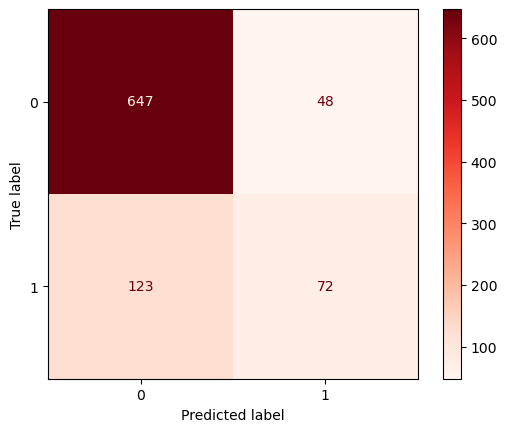

In [61]:
#menampilkan hasil data test dengan metode random search
y_pred_test_finals = rf_gridcv_best.predict(X_test_final)

print('F1 Score - Test Set  : ', f1_score(y_test, y_pred_test_finals), '\n')
print('Classification Report : \n', classification_report(y_test, y_pred_test_finals), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(rf_gridcv_best, X_test_final, y_test, cmap='Reds'))

didapat nilai defult KNN f1_score random search memiliki nilai range train 0.88 dan test 0.43

# **Model Evaluation**

In [62]:
# membuat table baru default untuk nantinya membandingkan dengan nilai f1 score test yang default dan yang sudah dengan menggunakan random seach
all_reports = {}
def performance_report(all_reports, y_trains, y_train_predict_knn, y_test, y_test_predict_knn, name):
  score_reports = {
      'train - precision' : precision_score(y_trains, y_train_predict_knn),
      'train - recall' : recall_score(y_trains, y_train_predict_knn),
      'train - accuracy' : accuracy_score(y_trains, y_train_predict_knn),
      'train - f1_score' : f1_score(y_trains, y_train_predict_knn),
      'test - precision' : precision_score(y_test, y_test_predict_knn),
      'test - recall' : recall_score(y_test, y_test_predict_knn),
      'test - accuracy_score' : accuracy_score(y_test, y_test_predict_knn),
      'test - f1_score' : f1_score(y_test, y_test_predict_knn),
  }
  all_reports[name] = score_reports
  return all_reports

all_reports = performance_report(all_reports, y_trains, y_train_predict_knn, y_test, y_test_predict_knn, 'Baseline (Default Hyperparameter)')
pd.DataFrame(all_reports)

,Baseline (Default Hyperparameter)
test - accuracy_score,0.762921
test - f1_score,0.465823
test - precision,0.460000
test - recall,0.471795
train - accuracy,0.811009
train - f1_score,0.797510
train - precision,0.858857
train - recall,0.744343


In [63]:
# menampilkan tabel perbandingan nilai dari f1 test yang default dan dengan metode random search
all_reports = performance_report(all_reports, y_trains, y_pred_train_finals, y_test, y_pred_test_finals, 'grid search')
pd.DataFrame(all_reports)

,Baseline (Default Hyperparameter),grid search
train - precision,0.858857,0.891499
train - recall,0.744343,0.487462
train - accuracy,0.811009,0.714067
train - f1_score,0.797510,0.630289
test - precision,0.460000,0.600000
test - recall,0.471795,0.369231
test - accuracy_score,0.762921,0.807865
test - f1_score,0.465823,0.457143


saya tetap memakai model KNN yang default dikarenakan test f1 score menngalami penurunan saat dilakukan hypertunning dan model juga memiliki kencederungan overfit nilai train bagus tapi nilai test tidak

In [64]:
# define fungsi KNN yang akan digunakan
model_knn=KNeighborsClassifier().fit(X_train_finals,y_trains)

# **Model Saving**

In [65]:

# Menyimpan objek 'model_knn' ke dalam berkas 'model_knn.pkl' menggunakan modul 'pickle'
with open('model_grid.pkl', 'wb') as file_2:
    pickle.dump(rf_gridcv_best, file_2)

# **Model Inference**

In [66]:
# Model loading
with open('model_grid.pkl', 'rb') as file_load:
    model = pickle.load(file_load)

In [69]:
# Membuat Data Baru

# Membuat data baru dengan informasi jarak, pengali lonjakan, dan nama armada
data_inf = {
    "limit_balance": [75000, 120000],
    "pay_0": [-1, 1],
    "pay_2": [-1, 2],
    "pay_3": [-1, 1],
    "pay_4": [0, 1],
    "pay_5": [0, 1],
    "pay_6": [2, 1],
}

# Membuat DataFrame dari data baru
data_in = pd.DataFrame(data_inf)

# Menampilkan data baru
data_in

,limit_balance,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6
0,75000,-1,-1,-1,0,0,2
1,120000,1,2,1,1,1,1


In [70]:
# Predict
y_inf_pred = model.predict(data_in.values)
y_inf_pred

array([0, 1], dtype=int64)

# **Kesimpulan**

kesimpulan yang dapat diambil adalah model yang paling bagus untuk dipakai adalah model KNN dan saat melakukan hyper tunning hasilnya malah dapat penurunan di f1 score oleh sebab itu model yang dilakukan untuk prediksi diambil model tanpa hypertunning

# **COnceptual Problem**

**1. Apakah yang dimaksud dengan coeficient pada logistic regression?** adalah parameter yang digunakan untuk menggambarkan hubungan antara variabel independen(predictor) dengan probabilitas kejadian pada model regresi logistik.

**2. Apakah fungsi parameter kernel pada SVM? Jelaskan salah satu kernel yang kalian pahami!** adalah fungsi matematis yang digunakan untuk mengubah data dari representasi awalnya ke ruang fitur yang berbeda. RBF Kernel mengubah data ke ruang dimensi tak terbatas. 

**3. Bagaimana cara memilih K yang optimal pada KNN ?** dengan menggunakan cross-validation ataupun dengan menggunakan grid search

**4. Apa yang dimaksud dengan metrics-metrics berikut : Accuracy, Precision, Recall, F1 Score, dan kapan waktu yang tepat untuk menggunakannya ?** 
- **accuracy** mengukur sejauh mana model benar dalam memprediksi kelas. Waktu yang tepat untuk menggunakannya ketika semua kelas dalam masalah klasifikasi memiliki tingkat penting yang sama. Namun, akurasi bisa menjadi bias jika ada ketidakseimbangan kelas (imbalance class) dalam dataset.
- **precision** mengukur sejauh mana prediksi positif yang benar dari model. Waktu yang tepat untuk menggunakannya ketika ingin meminimalkan false positive (kasus di mana model memprediksi positif ketika seharusnya negatif) dan kelas positif memiliki tingkat penting yang tinggi.
- **recall** mengukur sejauh mana model mendeteksi semua instance positif yang sebenarnya. Waktu yang tepat untuk menggunakannya ketika ingin meminimalkan false negative (kasus di mana model memprediksi negatif ketika seharusnya positif) dan kelas positif memiliki tingkat penting yang tinggi.
- **f1 score** adalah metrik yang menggabungkan precision dan recall untuk memberikan gambaran keseluruhan tentang kinerja model. Waktu yang tepat untuk menggunakannya ketika ingin mencari keseimbangan antara precision dan recall.